# K-Means

In [1]:
import sys
from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import psycopg2.extras

root_path = Path().resolve().parent.parent
sys.path.append(str(root_path))

from src.dataset.connection import connect_to_spotify_dataset
from src.dataset.connection import select

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn.functional as F

from sklearn.metrics import silhouette_score, davies_bouldin_score

In [2]:
connection = connect_to_spotify_dataset(json_file = 'security_details.json') # Add db Password
if not connection:
    print("Connection Error")
tds = select(connection, "SELECT * FROM track_data") 

Connection successful
Connection closed.


In [3]:
columns = [
    "id", "name", "popularity", "duration_ms", "explicit", "artists", "id_artists", "release_date",
    "danceability", "energy", "key", "loudness", "mode", "speechiness", "acousticness", 
    "instrumentalness", "liveness", "valence", "tempo", "time_signature","decade", "mood_index", "emotion_index", "party_index", "chill_index"
]
# Create the DataFrame
df = pd.DataFrame(tds, columns=columns)
print(df.dtypes)
df.head()

id                   object
name                 object
popularity            int64
duration_ms           int64
explicit               bool
artists              object
id_artists           object
release_date         object
danceability        float64
energy              float64
key                   int64
loudness            float64
mode                   bool
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
time_signature        int64
decade                int64
mood_index          float64
emotion_index       float64
party_index         float64
chill_index         float64
dtype: object


,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,...,instrumentalness,liveness,valence,tempo,time_signature,decade,mood_index,emotion_index,party_index,chill_index
0,3KD6IGlsy0OmvQ5EZVSGwf,Iris: Inno al sole,0,231987,False,"[Pietro Mascagni, Staatskapelle Berlin]","[3Z5fRknMBBNfCw6pkgR9S8, 7vEPPI71V8dEHtEhPMAxWT]",1927-04-01,0.188,0.1390,...,0.902000,0.8170,0.0387,74.178,3,1920,0.10355,5.63778,0.16350,0.93120
1,3YmijQy1yo6Eqh7cLeHL5Z,Derecho Viejo - Instrumental (Remasterizado),0,165000,False,[Francisco Canaro],[2maQMqxNnlRrBrS1oAsrX9],1927-08-20,0.895,0.2710,...,0.520000,0.0993,0.7610,118.060,4,1920,0.70320,3.47780,0.58300,0.88560
2,3ZP4TJ7FGj14NDddfUo62v,I Wanna Hot Dog For My Roll - Live,0,208867,False,[Butterbeans & Susie],[7x8h8nMdamj4hpSrAuwN9I],1927,0.593,0.1690,...,0.000000,0.9120,0.4740,95.664,4,1920,0.44870,4.65450,0.38100,0.92280
3,3mjnqRwgLJ1zVMXzygA1Yn,Por Mi Honor - Instrumental (Remasterizado),0,188107,False,[Francisco Canaro],[2maQMqxNnlRrBrS1oAsrX9],1927-09-17,0.818,0.0793,...,0.952000,0.1030,0.9350,113.814,4,1920,0.72876,7.51049,0.44865,0.96588
4,4BtCiPyckSyWOU34bAWD8A,Chapter 12.2 & Chapter 13.1 - Sprawy Sherlocka...,0,143265,False,[Arthur Conan Doyle],[2AcBhTO6Q3zzUrfPKmskp3],1927-07-29,0.721,0.3020,...,0.000002,0.1120,0.7120,117.030,5,1920,0.63270,6.03760,0.51150,0.80780


# PCA

In [4]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

selected_columns = ['popularity', 'duration_ms', 'explicit', 'danceability', 'energy', 'key',
                    'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
                    'liveness', 'valence', 'tempo', 'decade',"mood_index","emotion_index","party_index","chill_index"]

X = df[selected_columns]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA()
X_pca = pca.fit_transform(X_scaled)

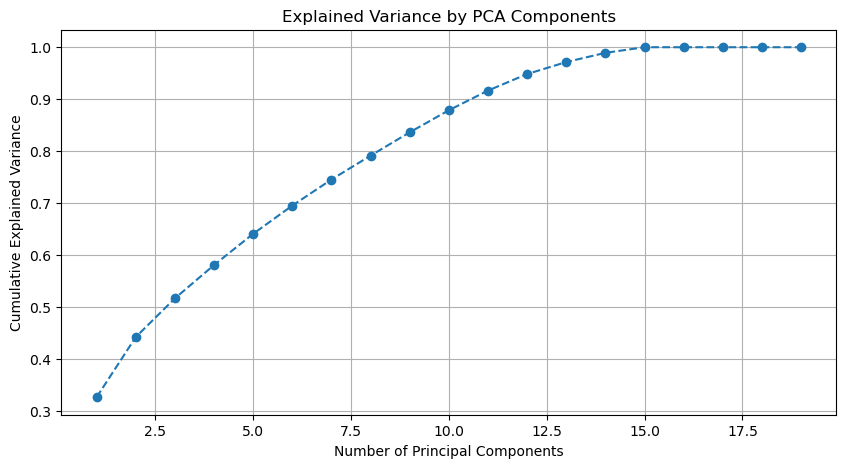

In [5]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(selected_columns) + 1), np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by PCA Components')
plt.grid()
plt.show()

In [6]:
explained_variance = np.cumsum(pca.explained_variance_ratio_)
n_components = np.argmax(explained_variance >= 0.95) + 1  # Get number of components for 95% variance

print(f"Number of components needed to explain 95% variance: {n_components}")

pca_final = PCA(n_components=n_components)
X_pca_final = pca_final.fit_transform(X_scaled)

df_pca = pd.DataFrame(X_pca_final, columns=[f'PC{i+1}' for i in range(n_components)])

Number of components needed to explain 95% variance: 13


In [7]:
df_pca

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13
0,6.623513,0.935577,-0.835520,3.111189,0.664170,1.409538,1.173034,-1.349267,1.284934,-0.233185,1.414903,0.364529,-0.095561
1,1.718562,-3.639420,-1.059622,-0.595022,0.132705,-0.210021,0.169930,-0.823519,1.277919,0.426272,-0.292430,-1.784563,0.274525
2,3.577779,-1.825868,0.171104,2.813098,1.481710,-0.997122,1.184669,-0.909790,-0.833989,1.275083,1.080804,1.038460,0.711437
3,4.213460,-4.117173,-1.032951,-2.315742,3.004630,1.187307,-0.669553,-0.409500,0.687024,-0.032491,0.988685,0.004078,0.045056
4,2.954785,-4.480359,1.309193,1.345582,-0.713678,1.249698,-0.538360,-0.038596,-0.790027,0.434959,-2.477671,-1.456111,-0.991074
...,...,...,...,...,...,...,...,...,...,...,...,...,...
525582,1.571259,-3.037898,-2.073398,-0.406582,0.207623,0.533037,0.486139,-1.583932,1.635360,-0.017314,1.220275,-1.393998,-0.260855
525583,1.823652,-2.941102,-0.968966,-0.584327,0.986108,-0.179790,0.398474,-1.628679,-0.567399,0.221997,-0.208314,-0.329435,0.368153
525584,0.367736,-1.409699,-1.670282,1.295385,-0.885038,-1.348382,2.141578,-1.573808,0.875939,0.575058,-0.614133,-0.320171,-0.320742
525585,2.554092,-4.657463,1.888453,1.599435,1.795461,0.033669,0.203990,-0.254068,-0.914265,0.180363,-1.912765,-0.920434,-1.214302


In [8]:
# Compute variance of each feature
feature_variance = df[selected_columns].var()

# Sort features by variance (descending order)
feature_variance_sorted = feature_variance.sort_values(ascending=False)

print(feature_variance_sorted)

duration_ms         9.248533e+09
tempo               8.892337e+02
decade              5.233641e+02
popularity          3.352937e+02
loudness            2.599736e+01
key                 1.238093e+01
emotion_index       2.096494e+00
mode                2.252908e-01
acousticness        1.209080e-01
chill_index         8.355716e-02
instrumentalness    7.084767e-02
valence             6.646686e-02
energy              6.337540e-02
explicit            4.300033e-02
speechiness         3.490188e-02
mood_index          3.447737e-02
liveness            3.409099e-02
party_index         2.776405e-02
danceability        2.767026e-02
dtype: float64


# K-Means - SKLearn

In [10]:
df.head()

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,...,instrumentalness,liveness,valence,tempo,time_signature,decade,mood_index,emotion_index,party_index,chill_index
0,3KD6IGlsy0OmvQ5EZVSGwf,Iris: Inno al sole,0,231987,False,"[Pietro Mascagni, Staatskapelle Berlin]","[3Z5fRknMBBNfCw6pkgR9S8, 7vEPPI71V8dEHtEhPMAxWT]",1927-04-01,0.188,0.1390,...,0.902000,0.8170,0.0387,74.178,3,1920,0.10355,5.63778,0.16350,0.93120
1,3YmijQy1yo6Eqh7cLeHL5Z,Derecho Viejo - Instrumental (Remasterizado),0,165000,False,[Francisco Canaro],[2maQMqxNnlRrBrS1oAsrX9],1927-08-20,0.895,0.2710,...,0.520000,0.0993,0.7610,118.060,4,1920,0.70320,3.47780,0.58300,0.88560
2,3ZP4TJ7FGj14NDddfUo62v,I Wanna Hot Dog For My Roll - Live,0,208867,False,[Butterbeans & Susie],[7x8h8nMdamj4hpSrAuwN9I],1927,0.593,0.1690,...,0.000000,0.9120,0.4740,95.664,4,1920,0.44870,4.65450,0.38100,0.92280
3,3mjnqRwgLJ1zVMXzygA1Yn,Por Mi Honor - Instrumental (Remasterizado),0,188107,False,[Francisco Canaro],[2maQMqxNnlRrBrS1oAsrX9],1927-09-17,0.818,0.0793,...,0.952000,0.1030,0.9350,113.814,4,1920,0.72876,7.51049,0.44865,0.96588
4,4BtCiPyckSyWOU34bAWD8A,Chapter 12.2 & Chapter 13.1 - Sprawy Sherlocka...,0,143265,False,[Arthur Conan Doyle],[2AcBhTO6Q3zzUrfPKmskp3],1927-07-29,0.721,0.3020,...,0.000002,0.1120,0.7120,117.030,5,1920,0.63270,6.03760,0.51150,0.80780


In [11]:
#duration, tempo, decade, popularity, key, emotion index, mode, chill index
df_kmeans = df[['duration_ms', 'tempo', 'decade', 'popularity', 'key', 'emotion_index', 'mode', 'chill_index']]
df_kmeans.head()

,duration_ms,tempo,decade,popularity,key,emotion_index,mode,chill_index
0,231987,74.178,1920,0,2,5.63778,True,0.93120
1,165000,118.060,1920,0,7,3.47780,True,0.88560
2,208867,95.664,1920,0,5,4.65450,False,0.92280
3,188107,113.814,1920,0,11,7.51049,False,0.96588
4,143265,117.030,1920,0,0,6.03760,True,0.80780


In [12]:
#pre-proc
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_kmeans)

In [13]:
inertia = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_scaled)
    inertia.append(kmeans.inertia_)  #sum of squared distances to cluster center

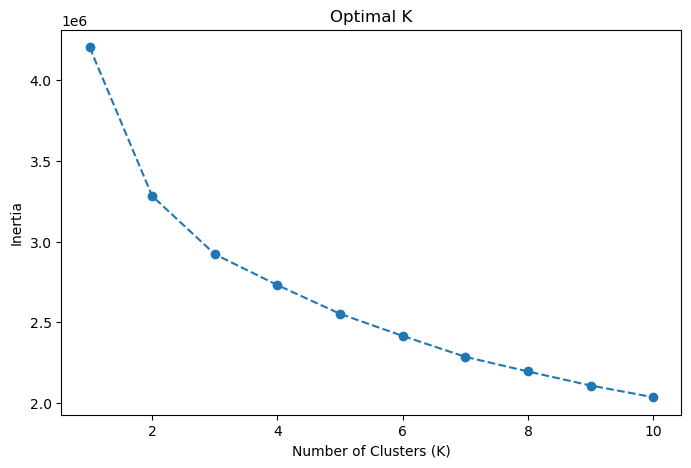

In [14]:
plt.figure(figsize=(8,5))
plt.plot(k_range, inertia, marker='o', linestyle='--')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.title('Optimal K')
plt.show()

In [15]:
optimal_k = 3 
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
#df['Cluster'] = kmeans.fit_predict(df_scaled)

In [16]:
df.head()

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,...,instrumentalness,liveness,valence,tempo,time_signature,decade,mood_index,emotion_index,party_index,chill_index
0,3KD6IGlsy0OmvQ5EZVSGwf,Iris: Inno al sole,0,231987,False,"[Pietro Mascagni, Staatskapelle Berlin]","[3Z5fRknMBBNfCw6pkgR9S8, 7vEPPI71V8dEHtEhPMAxWT]",1927-04-01,0.188,0.1390,...,0.902000,0.8170,0.0387,74.178,3,1920,0.10355,5.63778,0.16350,0.93120
1,3YmijQy1yo6Eqh7cLeHL5Z,Derecho Viejo - Instrumental (Remasterizado),0,165000,False,[Francisco Canaro],[2maQMqxNnlRrBrS1oAsrX9],1927-08-20,0.895,0.2710,...,0.520000,0.0993,0.7610,118.060,4,1920,0.70320,3.47780,0.58300,0.88560
2,3ZP4TJ7FGj14NDddfUo62v,I Wanna Hot Dog For My Roll - Live,0,208867,False,[Butterbeans & Susie],[7x8h8nMdamj4hpSrAuwN9I],1927,0.593,0.1690,...,0.000000,0.9120,0.4740,95.664,4,1920,0.44870,4.65450,0.38100,0.92280
3,3mjnqRwgLJ1zVMXzygA1Yn,Por Mi Honor - Instrumental (Remasterizado),0,188107,False,[Francisco Canaro],[2maQMqxNnlRrBrS1oAsrX9],1927-09-17,0.818,0.0793,...,0.952000,0.1030,0.9350,113.814,4,1920,0.72876,7.51049,0.44865,0.96588
4,4BtCiPyckSyWOU34bAWD8A,Chapter 12.2 & Chapter 13.1 - Sprawy Sherlocka...,0,143265,False,[Arthur Conan Doyle],[2AcBhTO6Q3zzUrfPKmskp3],1927-07-29,0.721,0.3020,...,0.000002,0.1120,0.7120,117.030,5,1920,0.63270,6.03760,0.51150,0.80780


# K-Means - PyTorch

In [17]:
# Pre-proc: convert to PyTorch tensor
X = torch.tensor(df_scaled, dtype=torch.float32) 

In [19]:
def compute_inertia(X, k_values):
    """
    Computes inertia (sum of squared distances to the nearest centroid) for different values of k.

    Parameters:
    X (torch.Tensor): The dataset containing feature vectors.
    k_values (list): A list of k values to evaluate.

    Returns:
    list: A list of inertia values corresponding to each k.
    """
    inertia = [] 

    for k in k_values:
        # Randomly initialize k cluster centroids
        num_samples = X.shape[0] 
        random_indices = torch.randperm(num_samples)[:k]  # Randomly select k indices
        centroids = X[random_indices]  # Initial centroids

        # Run K-Means iteratively
        for iteration in range(50):  
            # Pairwise distances between data points and centroids
            distances = torch.cdist(X, centroids)  

            # Assign each data point to the nearest centroid
            labels = torch.argmin(distances, dim=1) 

            # Compute new centroids as the mean of assigned points
            new_centroids = []
            for i in range(k):
                cluster_points = X[labels == i]  
                if cluster_points.shape[0] > 0:
                    new_centroid = cluster_points.mean(dim=0) 
                else:
                    new_centroid = centroids[i]  # Keep old centroid if no points assigned
                new_centroids.append(new_centroid)
            
            # Convert list of tensors into a single tensor
            new_centroids = torch.stack(new_centroids)  

            # Check for convergence 
            centroid_shift = torch.norm(new_centroids - centroids)
            if centroid_shift < 1e-4:
                break  

            # Update centroids for the next iteration
            centroids = new_centroids  

        # Compute inertia 
        min_distances, idx_centroid = torch.min(torch.cdist(X, centroids), dim=1)  
        inertia_value = torch.sum(min_distances ** 2).item()  
        inertia.append(inertia_value) 

    return inertia  

In [ ]:
k_values = range(1, 11)
inertia_values = compute_inertia(X, k_values)

In [ ]:
plt.plot(k_values, inertia_values, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Optimal K")
plt.show()

In [26]:
def evaluate_clusters(X, k_values):
    """
    Evaluates different k-values using Silhouette Score and Davies Bouldin Index.

    Parameters:
    X (torch.Tensor): Data points.
    k_values (list): List of k values to evaluate.

    Returns:
    dict: Scores for each k.
    """
    scores = {"silhouette": {}, "davies_bouldin": {}}

    for k in k_values:
        # Initialize k-means with k clusters
        num_samples = X.shape[0]
        random_indices = torch.randperm(num_samples)[:k]
        centroids = X[random_indices]

        # Run K-Means clustering
        for j in range(50):  
            distances = torch.cdist(X, centroids)
            labels = torch.argmin(distances, dim=1)

            new_centroids = []
            for i in range(k):
                cluster_points = X[labels == i]
                if cluster_points.shape[0] > 0:
                    new_centroid = cluster_points.mean(dim=0)
                else:
                    new_centroid = centroids[i]
                new_centroids.append(new_centroid)

            new_centroids = torch.stack(new_centroids)
            if torch.norm(new_centroids - centroids) < 1e-4:
                break

            centroids = new_centroids

        # Compute Silhouette Score and DBI
        labels_np = labels.numpy()
        X_np = X.numpy()

        silhouette = silhouette_score(X_np, labels_np) if k > 1 else -1  # Requires at least 2 clusters
        dbi = davies_bouldin_score(X_np, labels_np) if k > 1 else float("inf")  # Higher k means more separation

        scores["silhouette"][k] = silhouette
        scores["davies_bouldin"][k] = dbi

        print(f"k={k}: Silhouette Score = {silhouette:.4f}, Davies-Bouldin Index = {dbi:.4f}")

    return scores


In [ ]:
k_values = range(1, 11)  
scores = evaluate_clusters(X, k_values)

k=1: Silhouette Score = -1.0000, Davies-Bouldin Index = inf


In [ ]:
scores

In [ ]:
k = 4 
max_iters = 100  
tol = 1e-4 

# Randomly initialize cluster centroids
num_samples = X.shape[0]  
random_indices = torch.randperm(num_samples)[:k]  
centroids = X[random_indices]  

# K-Means 
for iteration in range(max_iters):  
    print(f"Iteration {iteration + 1}") 

    # Compute distances between each data point and centroid
    distances = torch.cdist(X, centroids)  

    # Assign each data point to the nearest centroid
    labels = torch.argmin(distances, dim=1)  

    # Compute new centroids by averaging all points assigned to each cluster
    new_centroids = []  

    for cluster_id in range(k):
        cluster_points = X[labels == cluster_id]  

        if cluster_points.shape[0] > 0:  
            new_centroid = cluster_points.mean(dim=0)
        else:
            new_centroid = centroids[cluster_id]  

        new_centroids.append(new_centroid)  

    new_centroids = torch.stack(new_centroids)  

    # Check for convergence
    centroid_shift = torch.norm(new_centroids - centroids)  
    print(f"Centroid shift: {centroid_shift:.6f}") 

    if centroid_shift < tol:  
        break  

    # Update centroids for the next iteration
    centroids = new_centroids

df["cluster"] = labels.numpy()  